In [1]:
#####################################################
## @author : Yash Sharma
## @email: yashuvats.42@gmail.com
#####################################################

In [2]:
#### importing necessary modules and libraries
import sys
sys.path.append("/Users/yash/Desktop/yash-mtp/src/common")
from Model import *
from SilenceRemover import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchaudio
import os
import sys
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from datasets import load_dataset, Audio
from dataclasses import dataclass
from datasets import load_dataset, load_metric, load_from_disk, disable_caching
from transformers.file_utils import ModelOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
from transformers import AutoFeatureExtractor, TrainingArguments, AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, EvalPrediction, Trainer
import numpy as np
from typing import Any, Dict, Union, Tuple
import torch
from packaging import version
from torch import nn
from huggingface_hub import login
from torch import optim
import random
from torch.autograd import Variable
import multiprocessing
import concurrent.futures
from gaussianSmooth import *
from denoiser import pretrained
from denoiser.dsp import convert_audio
from noisereduce.torchgate import TorchGate as TG

from IPython.display import Audio
from pprint import pprint
# Load Silero VAD model
USE_ONNX = False  # change this to True if you want to test onnx model
if USE_ONNX:
    !pip install -q onnxruntime

model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                            #   force_reload=True,
                              onnx=USE_ONNX)

(get_speech_timestamps,
 save_audio,
 read_audio,
 _,
 collect_chunks) = utils

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/transformers/utils/generic.py:260: UserWa

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
nc = 11 # Number of language classes 
n_epoch = 200 # Number of epochs
look_back1 = 21 # range
IP_dim = 1024*look_back1 # number of input dimension
path = "/Users/yash/Desktop/MTP-2k23-24"
xVectormodel_path = "/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/model_xVector.pth"
window_size = 32000
resultDERPath = "/Users/yash/Desktop/yash-mtp/datasets/rttm"
max_batch_frames = 128
hop_length_seconds = 0.25 # Desired hop length in seconds

Device: cpu


In [27]:
### Intializing models
## for wave2vec2
model_name_or_path = "yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor"
offline_path = "/Users/yash/Downloads/displace-2sec-2lang-wave2vec2"
offline_path = model_name_or_path
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model_wave2vec2 = Wav2Vec2ForSpeechClassification.from_pretrained(offline_path).to(device)
target_sampling_rate = processor.feature_extractor.sampling_rate


### for x-vector
model_xVector = X_vector(IP_dim, nc)
# model.cuda()
optimizer =  optim.Adam(model_xVector.parameters(), lr=0.0001, weight_decay=5e-5, betas=(0.9, 0.98), eps=1e-9)
loss_lang = torch.nn.CrossEntropyLoss()  # cross entropy loss function for the softmax output
#####for deterministic output set manual_seed ##############
manual_seed = random.randint(1,10000) #randomly seeding
random.seed(manual_seed)
torch.manual_seed(manual_seed)

try:
    ## only use map location for non cuda devices
    model_xVector.load_state_dict(torch.load(xVectormodel_path, map_location=torch.device('cpu')), strict=False)
except Exception as err:
    print("Error is: ",err)
    print("No, valid/corrupted TDNN saved model found, Aborting!")

Some weights of the model checkpoint at yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor were not used when initializing Wav2Vec2ForSpeechClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor and are newly initialized: ['wav2vec2.encod

In [28]:
label_names = ['asm', 'ben', 'eng', 'guj', 'hin', 'kan', 'mal', 'mar', 'odi', 'tam', 'tel']
label2id = {'asm': 0, 'ben': 1, 'eng': 2, 'guj': 3, 'hin': 4, 'kan': 5, 'mal': 6, 'mar': 7, 'odi': 8, 'tam': 9, 'tel': 10}
id2label = {0: 'asm', 1: 'ben', 2: 'eng', 3: 'guj', 4: 'hin', 5: 'kan', 6: 'mal', 7: 'mar', 8: 'odi', 9: 'tam', 10: 'tel'}
print(f"label2id mapping: {label2id}")
print(f"id2label mapping: {id2label}")

label2id mapping: {'asm': 0, 'ben': 1, 'eng': 2, 'guj': 3, 'hin': 4, 'kan': 5, 'mal': 6, 'mar': 7, 'odi': 8, 'tam': 9, 'tel': 10}
id2label mapping: {0: 'asm', 1: 'ben', 2: 'eng', 3: 'guj', 4: 'hin', 5: 'kan', 6: 'mal', 7: 'mar', 8: 'odi', 9: 'tam', 10: 'tel'}


In [29]:
processor.feature_extractor.return_attention_mask = True
processor

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "Wav2Vec2Processor",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: Wav2Vec2CTCTokenizer(name_or_path='yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor', vocab_size=32, model_max_length=9223372036854775807, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True)

In [30]:
def preProcessSpeech(path):
    # Load audio with librosa
    global target_sampling_rate
    audio, sr =  librosa.load(path, sr = target_sampling_rate, mono = True)
    # clips = librosa.effects.split(audio, frame_length=8000, top_db=10) ## setting frame length 8000 and topdb=10 gave desirable results
    # clips = librosa.effects.split(audio) ## setting frame length 8000 and topdb=10 gave desirable results
    # wav_data = []
    # for c in clips:
    #     data = audio[c[0]: c[1]]
    #     wav_data.extend(data)
    # return np.array(wav_data)
    # Merge all speech chunks into one audio file and save it
    wav = read_audio(path, sampling_rate=target_sampling_rate)
    # Get speech timestamps using Silero VAD model
    speech_timestamps =  get_speech_timestamps(wav, model, sampling_rate=target_sampling_rate)
    speech_audio = collect_chunks(speech_timestamps, wav)
    return speech_audio.cpu().numpy()

## function to store the hidden feature representation from the last layer of wave2vec2
def getHiddenFeatures(frames):
    print(type(frames))
    features = processor(frames, sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
    input_values = features.input_values.to(device)
    attention_mask  = features.attention_mask.to(device)
    try:
        with torch.no_grad():
            # Pass attention_mask to the model to prevent attending to padded values
            hidden_features = model_wave2vec2.extract_hidden_states(input_values, attention_mask=attention_mask)
            logits = model_wave2vec2(input_values, attention_mask=attention_mask).logits 
            print(f"logits: {logits[:10]}")
            print("Hiden features size: ",hidden_features.shape)
            # print("Predictions from wave2vec2 for this batch: ",id2label[np.bincount(torch.argmax(logits, dim=-1).detach().cpu().numpy()).argmax()], end=",")
    except Exception as err:
        print(f"Error -> {err} \nSKIPPED! Input Length was: {len(frames[-1])} and features len was : {input_values.shape}")
    return hidden_features

def inputTDNN(hidden_features):
    #### Function to return data (vector) and target label of a csv (MFCC features) file
    # print("Shape of individual hidden features: ",hidden_features.shape)
    X = hidden_features.reshape(-1,1024)
    Xdata1 = []
    for i in range(0,len(X)-look_back1,1):    #High resolution low context        
        a = X[i:(i+look_back1),:]  
        b = [k for l in a for k in l]      #unpacking nested list(list of list) to list
        Xdata1.append(b)
    Xdata1 = np.array(Xdata1)    
    Xdata1 = torch.from_numpy(Xdata1).float() 
    return Xdata1

In [31]:
def extractHE(input_array):
    # Select columns eng and hindi
    selected_columns = input_array[:, [2, 4]]
    # Apply softmax along the second axis (axis=1)
    softmax_result = np.apply_along_axis(lambda x: np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x))), axis=1, arr=selected_columns)
    return softmax_result

In [32]:
def pipeline(path, max_batch_frames=max_batch_frames):
    ## Step 1: preprocess the audio by removing silence
    x = preProcessSpeech(path)
    
    ## Now, we will just break this audio into multiple overlapping windows 
    # Calculate the hop size in samples
    hop_size = int(hop_length_seconds * target_sampling_rate)  # Adjust 'sample_rate' as needed

    # Generate overlapping frames
    frames = [x[i:i+window_size] for i in range(0, len(x) - window_size + 1, hop_size)]
    print(f"len of frames {len(frames)}")
    if len(frames[-1]) < 100:
        print(f"Last element has small length of {len(frames[-1])} while it shall be {len(frames[0])}, Dropping!")
        frames.pop()
    
    ## Step 2: get the hidden feature for the processed output / here #frames acts as batch size
    results = []
    end = len(frames)  # Initialize end index to the total number of frames
    for i in range(0, end, max_batch_frames):
        batch_frames = frames[i:min(i+max_batch_frames, end)]  # Adjust end index
        hidden_features = getHiddenFeatures(batch_frames).cpu().numpy()
        # print(f"size of hidden features: {hidden_features.shape}")
        results.append(hidden_features)

    ## Concatenate results of all minibatches
    x = np.concatenate(results, axis=0)
    # print(f"Final shape of hidden features concatenated: {x.shape}")
    ## Step 3: get the output of TDNN for both eng and hindi
    X_val = torch.from_numpy(np.vectorize(inputTDNN, signature='(n,m)->(p,q)')(x))  ## returns (#frames, 28, 21504)
    X_val = Variable(X_val, requires_grad=False)
    model_xVector.eval()  # Set the model to evaluation mode
    val_lang_op = model_xVector.forward(X_val)
    val_lang_op = val_lang_op.detach().cpu().numpy()
    val_lang_op = np.vectorize(extractHE, signature='(n,m)->(n,p)')(val_lang_op)
    
    ## Step 4: mask the output for all language except eng and hindi
    return val_lang_op[:,0], val_lang_op[:,1]


In [33]:
def voice_activity_detection_silero(audio_file, sampling_rate):
    # Read audio file
    audio_data = read_audio(audio_file, sampling_rate=sampling_rate)

    # Get speech timestamps using Silero VAD model
    speech_timestamps =  get_speech_timestamps(audio_data, model, sampling_rate=target_sampling_rate)

    # Construct a list of voice segments and a dictionary containing start and end times
    voice_segments = []
    voice_segments_dict = {}
    for i, timestamp in enumerate(speech_timestamps):
        if isinstance(timestamp, int):
            # If the timestamp is an integer, treat it as the start time of a segment
            start_time = timestamp / sampling_rate
            end_time = start_time  # Set end time equal to start time
            duration = 0  # Duration is 0 for single point
        else:
            # If the timestamp is a dictionary, extract start and end times
            start_time = timestamp['start'] / sampling_rate
            end_time = timestamp['end'] / sampling_rate
            duration = end_time - start_time
        
        voice_segments.append((start_time, end_time, duration))
        voice_segments_dict[f"segment_{i+1}"] = {"start": start_time, "end": end_time}

    return voice_segments, voice_segments_dict, speech_timestamps


In [34]:
# print(type(speech_audio.cpu().numpy()))

In [35]:
audio_path = "/Users/yash/Desktop/yash-mtp/datasets/audios/B038.wav"
ref_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE.rttm"
# speech, sr = librosa.load(audio_path, sr=target_sampling_rate)
# plt.plot(speech)
# print("Original sampling Rate: ",sr)
# voice_segments, voice_segments_dict , speech_timestamps= voice_activity_detection_silero(audio_path, sampling_rate=target_sampling_rate)
# pprint(voice_segments)
# pprint(voice_segments_dict)

# # Merge all speech chunks into one audio file and save it
# wav = read_audio(audio_path, sampling_rate=target_sampling_rate)
# speech_audio = collect_chunks(speech_timestamps, wav)
# save_audio('/Users/yash/Desktop/yash-mtp/datasets/only_speech.wav', speech_audio, sampling_rate=target_sampling_rate)

# # Display the audio with only speech
# Audio('/Users/yash/Desktop/yash-mtp/datasets/only_speech.wav')

Original sampling Rate:  16000


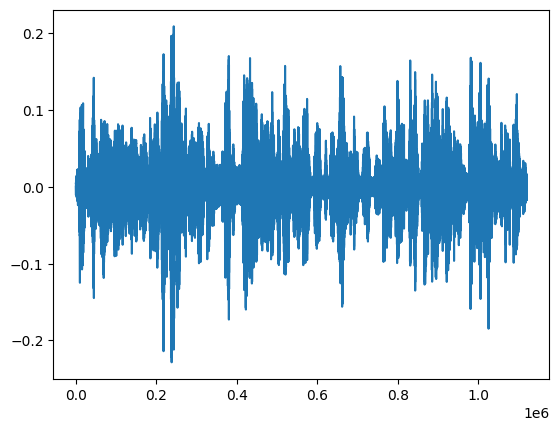

In [36]:

audio_path = "/Users/yash/Desktop/yash-mtp/datasets/audios/B038.wav"
# audio_path = '/Users/yash/Desktop/yash-mtp/datasets/only_speech.wav'
ref_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE.rttm"
speech, sr = torchaudio.load(audio_path)
speech = speech[0].numpy().squeeze()
plt.plot(speech)
print("Original sampling Rate: ",sr)
# # Resample the audio signal to a target sampling rate of 16,000 Hz
# speech = librosa.resample(speech, orig_sr=sr, target_sr=16000)
ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000))
# # with torch.no_grad():
# #     denoised_speech = denoiser(torch.tensor(speech[:128000])[None][None])[0]
# # ipd.display(ipd.Audio(denoised_speech.data.cpu().numpy(), rate=denoiser.sample_rate))
# # audio = speech
# # reduced_noise = nr.reduce_noise(y=audio, sr=target_sampling_rate, stationary=True, prop_decrease=0.25)
# # board = Pedalboard([
# #     NoiseGate(threshold_db=-30, ratio=1.5, release_ms=250),
# #     Compressor(threshold_db=-16, ratio=2.5),
# #     LowShelfFilter(cutoff_frequency_hz=400, gain_db=10, q=1),
# #     Gain(gain_db=10)
# # ])

# # reduced_noise = board(reduced_noise, target_sampling_rate)
# # plt.plot(np.asarray(reduced_noise), alpha=0.75)
# # ipd.display(ipd.Audio(data=np.asarray(reduced_noise), autoplay=True, rate=16000))
ipd.display(ipd.Audio(data=np.asarray(preProcessSpeech(audio_path)), autoplay=True, rate=16000))

In [37]:
# if "data.npz" in os.listdir("/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/"):
#     print("Loading cached version!")
#     # Load the arrays from the NPZ file
#     loaded_data = np.load("data.npz")
#     S0 = loaded_data["s0"]
#     S1 = loaded_data["s1"]
# else:
#     print("Saved Version Not Found, calclating!")
#     S0, S1 = pipeline(audio_path)
#######
# directory = "/Users/yash/Desktop/MTP-2k23-24/Bhashini_Test_Data"
# for audio_path in os.listdir(directory):
#     print("Current Audio: ",audio_path)
#     audio_path = os.path.join(directory,audio_path)
#     S0, S1 = pipeline(audio_path)
#     print("-*-"*10)
    

S0, S1 = pipeline(audio_path)
print("English/ S0 shape: ", S0.shape)
print("Hindi/ S1 shape: ", S1.shape)
# Save s0 and s1 to an NPZ file
# np.savez("data_femalehe.npz", s0=S0, s1=S1)
# np.array(dummy)

# loaded_data = np.load("data.npz")
# S0 = loaded_data["s0"]
# S1 = loaded_data["s1"]

len of frames 251
<class 'list'>
logits: tensor([[-2.7538e+00,  9.9683e-01, -2.1395e+00, -1.4153e+00,  2.2637e+00,
         -4.5885e-01, -1.1742e+00,  9.8141e-01,  1.3415e+00, -9.7592e-02,
          9.1115e-01],
        [-1.4702e+00,  1.4216e+00, -2.4392e+00, -1.3220e+00,  1.1161e+00,
         -1.4878e+00, -1.2922e+00,  7.9902e-01,  2.0381e+00, -6.4910e-01,
          1.6757e+00],
        [-2.1258e+00,  2.4295e+00, -2.7520e+00,  1.0341e+00,  6.2919e-01,
         -3.6632e-01, -4.4348e+00,  5.0755e-01,  2.1127e+00, -3.8563e-01,
          2.3680e+00],
        [-1.5680e+00,  3.5865e+00, -2.1488e+00, -1.9506e-01,  6.3863e-01,
         -1.4952e+00, -3.8250e+00,  1.4159e+00,  1.5808e+00, -1.8806e+00,
          2.5687e+00],
        [-1.4791e+00,  2.4786e+00, -3.0067e+00,  2.8215e+00,  1.1314e-01,
         -5.2717e-01, -5.4868e+00,  9.1528e-01,  7.4272e-01, -1.1875e+00,
          3.5129e+00],
        [-1.3745e+00,  3.2852e+00, -1.1071e+00,  1.0734e-02, -3.0308e-01,
         -7.4594e-05, -3.6512e

In [42]:
gauss_window_size = 21  # A good starting value for the window size
sigma = 0.003*21  # A reasonable starting value for sigma

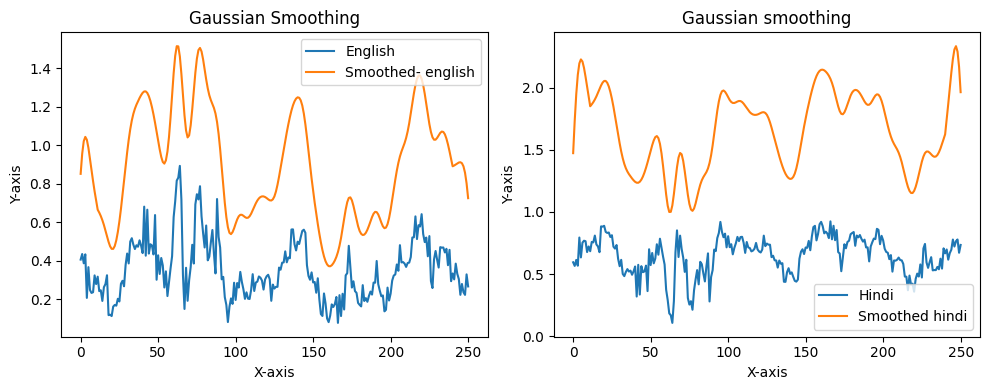

In [39]:
def visualizeSmoothing(S0, S1):
    # Create a figure with two subplots (side by side)
    plt.figure(figsize=(10, 4))

    # Plot the original vectors on the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(S0, label="English")
    plt.plot(gauss_smoothen(S0, sigma, window_size), label="Smoothed- english")
    plt.title("Gaussian Smoothing")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Plot the smoothed vectors on the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(S1, label="Hindi")
    plt.plot(gauss_smoothen(S1, sigma, window_size), label="Smoothed hindi")
    plt.title("Gaussian smoothing")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Adjust layout to avoid overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show()
visualizeSmoothing(S0, S1)

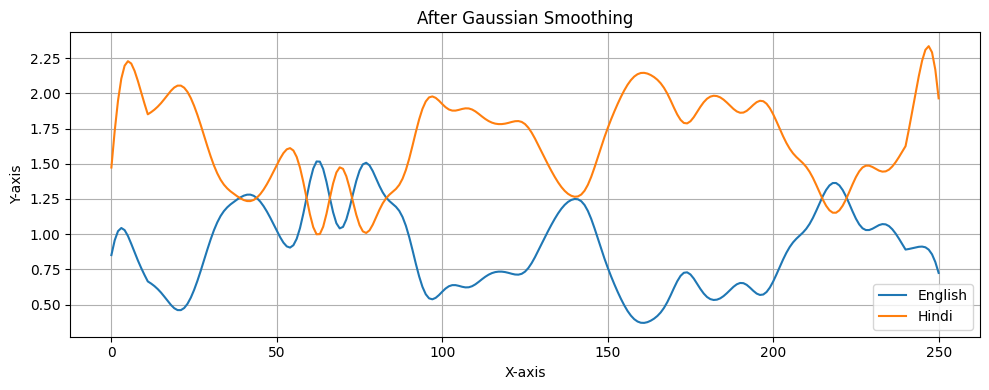

In [40]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(10, 4))

# Plot the original vectors on the first subplot
plt.plot(gauss_smoothen(S0, sigma, window_size), label="English")
plt.plot(gauss_smoothen(S1, sigma, window_size), label="Hindi")
plt.title("After Gaussian Smoothing")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
# Adjust layout to avoid overlapping labels
plt.tight_layout()
plt.grid()
# Show the plot
plt.show()

#### Visualize the real and calculated CP with labels

### Now, we will use the technique of languauge diarization to find the change points following the research paper

In [43]:
def diarize(S0,S1):
    ## Step 1: gaussian smooth all the input 
    S0  = np.array(gauss_smoothen(S0, sigma, gauss_window_size))
    S1 = np.array(gauss_smoothen(S1, sigma, gauss_window_size))

    ## Step 2: take signum of signed differece 
    # print(f"S0-S1: {S0-S1}")
    x = np.sign(S0 - S1)
    # print(f"2. After signum: {x}")
    x1 = []
    ## Step 3: take first order difference
    for i in range(1,len(x)-1):
        x1.append(x[i+1] - x[i])
    x1.append(x[len(x)-1])
    x1 = np.array(x1)
    # print(f"2. After firstorder difference:{x1}")
    x = x1
    ## Step 4: Find final cp's and the language labels
    x = 0.50*x
    # print(f"3. After 0.5*x: {x}")
    x = np.abs(x)
    # print(f"4. After abs: {x}")
    x = np.where(x == 1)
    # print("Change points are: ", x)
    SL = []
    for i in range(0, len(S0)):
        if S0[i]>S1[i]:
            SL.append(0)
        else:
            SL.append(1)
    if len(x[0]) == 0:
        ## dummy lang labels
        lang_labels = np.zeros((len(x[0])+1,), dtype=int)
        return x, lang_labels
    try: 
        lang_labels = [np.argmax(np.bincount(SL[:math.ceil(x[0][0])]))]
    except Exception as e:
        print("Lang lable extraction error: ",SL,"\n",e)
        lang_labels = np.zeros((len(x[0])+1,), dtype=int)
        return x, lang_labels
    for i in range(1,len(x[0])+1):
        lang_labels.append(1-lang_labels[i-1])
    # print("Segment Labels are: ", SL)
    # lang_labels = np.zeros(len(x)+1)
    return x, lang_labels

x, lang_labels = diarize(S0, S1)
print(x)
print(lang_labels)

(array([ 37,  42,  57,  65,  71,  82, 213, 221]),)
[1, 0, 1, 0, 1, 0, 1, 0, 1]


In [44]:
x = x[0]

In [45]:
x = (x*hop_length_seconds)+0.5
x

array([ 9.75, 11.  , 14.75, 16.75, 18.25, 21.  , 53.75, 55.75])

In [46]:
def generate_rttm_file(name,cp, predicted_labels, total_time):
    rttm_content = ""
    # Add the start time at 0
    start_time = 0
    tolang = {0:"L1",1:"L2"}
    for i in range(len(cp)):
        end_time = cp[i]
        # Calculate duration for each segment
        duration = end_time - start_time
        # Generate RTTM content
        rttm_content += f"LANGUAGE {name} 1 {start_time:.3f} {duration:.3f} <NA> <NA> {tolang[predicted_labels[i]]} <NA> <NA>\n"
        # rttm_content += f"Language {name} 1 {start_time:.3f} {duration:.3f} <NA> <NA> <NA> <NA>\n"

        # Update start time for the next segment
        start_time = end_time
    
    ## add last entry
    duration = total_time - start_time
    i = len(cp)
    # rttm_content += f"Language {name} 1 {start_time:.3f} {duration:.3f} <NA> <NA> <NA> <NA>\n"
    rttm_content += f"LANGUAGE {name} 1 {start_time:.3f} {duration:.3f} <NA> <NA> {tolang[predicted_labels[i]]} <NA> <NA>\n"
    output_rttm_filename = f"{name}_LANGUAGE_sys.rttm"
    targetPath = os.path.join(resultDERPath,output_rttm_filename)

    # Export RTTM file
    with open(targetPath, "w") as rttm_file:
        rttm_file.write(rttm_content)
    return targetPath

In [47]:
def extract_gcp(rttm_file_path):
    with open(rttm_file_path, 'r') as file:
        lines = file.readlines()

    gcp = []

    for line in lines:
        # Split the line by whitespace
        parts = line.split()

        # Extract relevant information
        gcp.append(float(parts[3]) + float(parts[4]))
    return gcp[:-1]

Ground Truth of change points: [4.254, 3.8890000000000002, 5.9159999999999995, 7.168, 8.132, 11.763, 12.533, 13.059999999999999, 13.969999999999999, 17.249000000000002, 18.942999999999998, 19.497, 19.889, 20.993, 22.682, 25.415999999999997, 26.759, 30.142, 32.456, 33.483000000000004, 35.077, 35.805, 36.575, 38.346000000000004, 47.45399999999999, 47.901, 53.231, 55.205, 56.854, 58.466, 62.173, 64.908, 64.18599999999999, 66.564]
Diralised Change points (Predicted): [ 9.75 11.   14.75 16.75 18.25 21.   53.75 55.75]
      Label: Codemixed Hindi English

Duration of the speech:  70.07


/var/folders/hw/9s_jqm8d44nfvywkt4hkr0qm0000gn/T/ipykernel_41567/2236299181.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(cp, 0, 'ro', color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")
/var/folders/hw/9s_jqm8d44nfvywkt4hkr0qm0000gn/T/ipykernel_41567/2236299181.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(cp, 0, 'ro', color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")


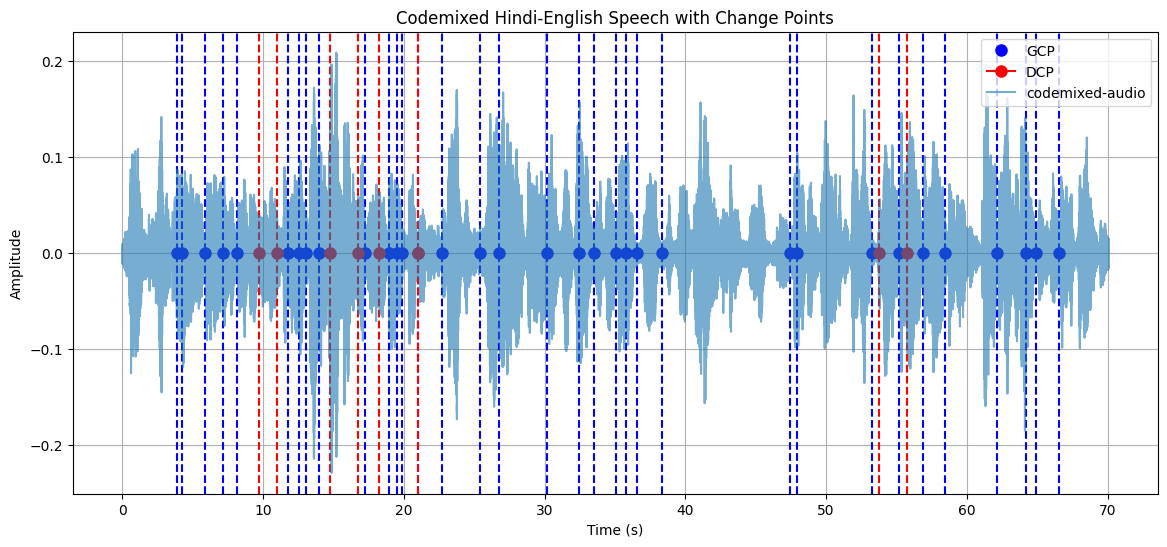

Original sampling Rate:  16000
Duration:  70.07
Before:  (1121120,) 
After:  (1121120,)


In [48]:
ref_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE.rttm"
def plotCP(audio_path, gcp, dcp):
    print(f"      Label: Codemixed Hindi English")
    print()
    gcp = np.array(gcp)
    dcp = np.array(dcp)
    speech, sr = torchaudio.load(audio_path)
    speech = speech[0].numpy().squeeze()
    print("Duration of the speech: ", len(speech) / sr)
    
    # Create a time vector in seconds
    time = np.arange(0, len(speech)) / sr

    plt.figure(figsize=(14, 6))
    i = 0
    # Add ground truth change points as circles
    for cp in gcp:
        plt.plot(cp, 0, 'ro', color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")
        plt.axvline(x=cp, color='blue', linestyle='--')
        i = 1

    i = 0
    # Add detected change points as vertical dashed lines
    for cp in dcp:
        plt.plot(cp, 0, marker='o', color='red', markersize=8, label='DCP' if i == 0 else "")
        plt.axvline(x=cp, color='red', linestyle='--')
        i = 1

    # Set plot labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Codemixed Hindi-English Speech with Change Points')

    # Show audio
    plt.plot(time, speech, label='codemixed-audio', alpha=0.6)

    # Show the plot
    plt.legend(loc=1)
    plt.grid()
    plt.show()

    print("Original sampling Rate: ", sr)
    print("Duration: ", len(speech) / sr)
    print("Before: ", speech.shape, "\nAfter: ", speech.shape)
    
    return ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sr)

# gcp = [4, 11, 19]  # Ground truth change points in seconds
gcp = extract_gcp(ref_rttm) 
name = audio_path.split("/")[-1].split(".")[0]
# Load the audio file using torchaudio
waveform, sample_rate = torchaudio.load(audio_path)
# Get the duration in seconds
duration_in_seconds = waveform.size(1) / sample_rate
sys_rttm = generate_rttm_file(name,x,lang_labels,duration_in_seconds)
# Ground truth change points in seconds
dcp = x  # Detected change points in seconds
print(f"Ground Truth of change points: {gcp}")
print(f"Diralised Change points (Predicted): {dcp}")
plotCP(audio_path, gcp, dcp)

In [49]:
import subprocess
import re

sys_rttm = "/Users/yash/Desktop/yash-mtp/datasets/rttm/B038_LANGUAGE_sys.rttm"
def run_command(command):
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, check=True, text=True)
        return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        return None

# Example command
command = f'python findDER.py -r "{ref_rttm}" -s "{sys_rttm}"'

# Run the command
output = run_command(command)
print(output)

# Extract the 4th integer from the last line of the output
if output:
    lines = output.split('\n')
    last_line = lines[-1].strip()

    # Use regular expression to extract integers
    floats = re.findall(r'-?\d+\.\d+', last_line)

    if len(floats) >= 1:
        der = floats[0]
        print(f"The required DER is : {der}")
    else:
        print("Enable to extract the integers.")
else:
    print("Command execution failed.")


File               DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
B038             47.18  66.19            0.44         0.80     0.57             0.02             0.02          1.35          0.50  0.02   0.02
*** OVERALL ***  47.18  66.19            0.44         0.80     0.57             0.02             0.02          1.35          0.50  0.02   0.02
The required DER is : 47.18


In [50]:
# dummy = []
# def pipeline(path):
#     ## Step 1: preprocees the audio by removing silence
#     x = preProcessSpeech(path)
#     ## Now, we will just bbreak this audio into multiple overlapping windows 
#     # Calculate the hop size in samples
#     hop_size = int(hop_length_seconds * target_sampling_rate)  # Adjust 'sample_rate' as needed

#     # Generate overlapping frames
#     frames = [x[i:i+window_size] for i in range(0, len(x) - window_size + 1, hop_size)]
#     # frames = [x]
#     S0 = []
#     S1 = []
#     dic = {0: "eng", 1: "hin"}
#     for frame in tqdm(frames):
#         ## Step 2: get the hidden featrue for the processed output
#         x = getHiddenFeatures(frame)
#         ## Step 3: get the output of TDNN for both eng and hindi
#         XX_val = inputTDNN(x)
#         XX_val = torch.unsqueeze(XX_val, 1)
#         X_val = np.swapaxes(XX_val, 0, 1)
#         X_val = Variable(X_val, requires_grad=False)
#         model_xVector.eval()  # Set the model to evaluation mode
#         val_lang_op =model_xVector.forward(X_val)
#         val_lang_op = val_lang_op.detach().cpu().numpy()[0]
#         val_lang_op = np.array([val_lang_op[2], val_lang_op[4]])
#         print("Before Softmax",val_lang_op)
#         y = dic[np.argmax(val_lang_op)]
#         ## apply softmax
#         val_lang_op = np.exp(val_lang_op)/np.sum(np.exp(val_lang_op))
#         print("After softmax: ",val_lang_op)
#         # print(f"Predicted language for this window is: ",y)
#         ## Step 4: mask the output for all languauge except eng and hindi
#         dummy.append(y)
#         # print(val_lang_op)
#         S0.append(val_lang_op[0])
#         S1.append(val_lang_op[1])
#     return np.array(S0), np.array(S1)
